In [2]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error as mse, r2_score



# Data Preparation

In [3]:
df = pd.read_csv('Final_Cleaned.csv', sep=';')
# Filtering out columns
new_column_names = {column: column.lower().replace(" ", "_") for column in df.columns}
df.rename(columns=new_column_names, inplace=True)
df.loc[df['land_area'].isna(), 'land_area'] = df['area']

columns_to_drop = ['road', 'seller', 'city', 'municipal', 'distance_to_copenhagen', 'distance_to_aarhus', 
                        'distance_to_odense', 'distance_to_aalborg','latitude', 'longitude', 'full_address', 'zip_address',
                        'link_to_seller', 'city_3', 'zip_address', 'city_2', 'zip',
                        'extra', 'latitude','longitude', 'sqm_price', 'days_at_current_seller']
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Drop identified columns
df_clean = df.drop(columns=columns_to_drop)
# Rest of the preprocessing steps

df_clean.describe()


,price,area,land_area,rooms,ejerudg,days_active,distance_to_city,residents,municipal_tax_rate,grundskyldspromille,age
count,2.652700e+04,26527.000000,2.652700e+04,26527.000000,26527.000000,26527.000000,26527.000000,26527.000000,26527.000000,26527.000000,26527.000000
mean,3.035100e+06,146.356429,6.123281e+03,4.636747,2827.248049,277.031817,37.954700,119061.139405,25.278412,26.160679,76.572096
std,3.325339e+06,66.044752,2.971769e+04,1.814347,1807.749102,334.064205,26.309026,150161.062474,0.818830,4.671925,53.883704
min,9.500000e+04,16.000000,0.000000e+00,1.000000,244.000000,0.000000,0.066130,1769.000000,23.100000,16.000000,-2.000000
25%,1.295000e+06,104.000000,3.000000e+02,3.000000,1795.000000,54.000000,14.290832,41662.000000,24.900000,22.850000,48.000000
50%,2.195000e+06,137.000000,7.870000e+02,4.000000,2384.000000,187.000000,36.592466,59193.000000,25.500000,25.000000,65.000000
75%,3.695000e+06,175.000000,1.181000e+03,6.000000,3317.500000,390.000000,57.810797,97358.000000,25.800000,29.700000,103.000000
max,1.000000e+08,790.000000,1.455054e+06,20.000000,57964.000000,4752.000000,99.990634,644431.000000,26.300000,34.000000,823.000000


Create dummies for property type, energy and closest city.

Remove the 2.5 pct lowest and highest observations from from 'price', 'area', 'land_area', 'rooms', 'ejerudg', 'days_active'

In [4]:
df_final = df_clean.copy()
building_type_counts = df_final['property_type'].value_counts()
top_building_types = building_type_counts.head(4).index.tolist()
df_final = df_final[df_final['property_type'].isin(top_building_types)]
dummy_1 = pd.get_dummies(df_final['property_type'], prefix='type', drop_first=True)
dummy_2 = pd.get_dummies(df_final['energy'], prefix='energy', drop_first=True)
dummy_3 = pd.get_dummies(df_final['closest_city'], prefix='close', drop_first=True)
df_final = pd.concat([df_final, dummy_1, dummy_2, dummy_3], axis=1)
df_final = df_final.drop(columns=['energy', 'closest_city']) #property_type
columns_to_remove_outliers = ['price', 'area', 'land_area', 'rooms', 'ejerudg', 'days_active']
for column in columns_to_remove_outliers:
    Q1 = df_final[column].quantile(0.025)
    Q3 = df_final[column].quantile(0.975)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_final = df_final[(df_final[column] >= lower_bound) & (df_final[column] <= upper_bound)]
df_final = df_final.drop_duplicates()
df_final.describe()

,price,area,land_area,rooms,ejerudg,days_active,distance_to_city,residents,municipal_tax_rate,grundskyldspromille,...,type_Villa,energy_B,energy_C,energy_D,energy_E,energy_F,energy_G,close_Aarhus,close_Copenhagen,close_Odense
count,2.612200e+04,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,...,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000,26122.000000
mean,2.902074e+06,144.678777,4070.289220,4.607457,2773.599112,268.957890,37.851992,119343.063318,25.279144,26.157379,...,0.791364,0.075186,0.313261,0.305183,0.132494,0.060447,0.036521,0.247990,0.322257,0.232065
std,2.664020e+06,62.474579,13848.637926,1.772036,1510.560628,298.782872,26.297757,150135.550764,0.817156,4.660158,...,0.406342,0.263696,0.463828,0.460494,0.339033,0.238318,0.187586,0.431854,0.467350,0.422158
min,9.500000e+04,16.000000,0.000000,1.000000,244.000000,0.000000,0.066130,1769.000000,23.100000,16.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.295000e+06,103.250000,291.000000,3.000000,1792.000000,54.000000,14.153815,41662.000000,24.900000,22.850000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.145000e+06,136.000000,781.000000,4.000000,2377.000000,187.000000,36.494168,59193.000000,25.500000,25.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.598000e+06,174.000000,1152.000000,6.000000,3298.750000,386.000000,57.754218,97358.000000,25.800000,29.700000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2.650000e+07,664.000000,146036.000000,19.000000,15063.000000,2644.000000,99.990634,644431.000000,26.300000,34.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Plot 

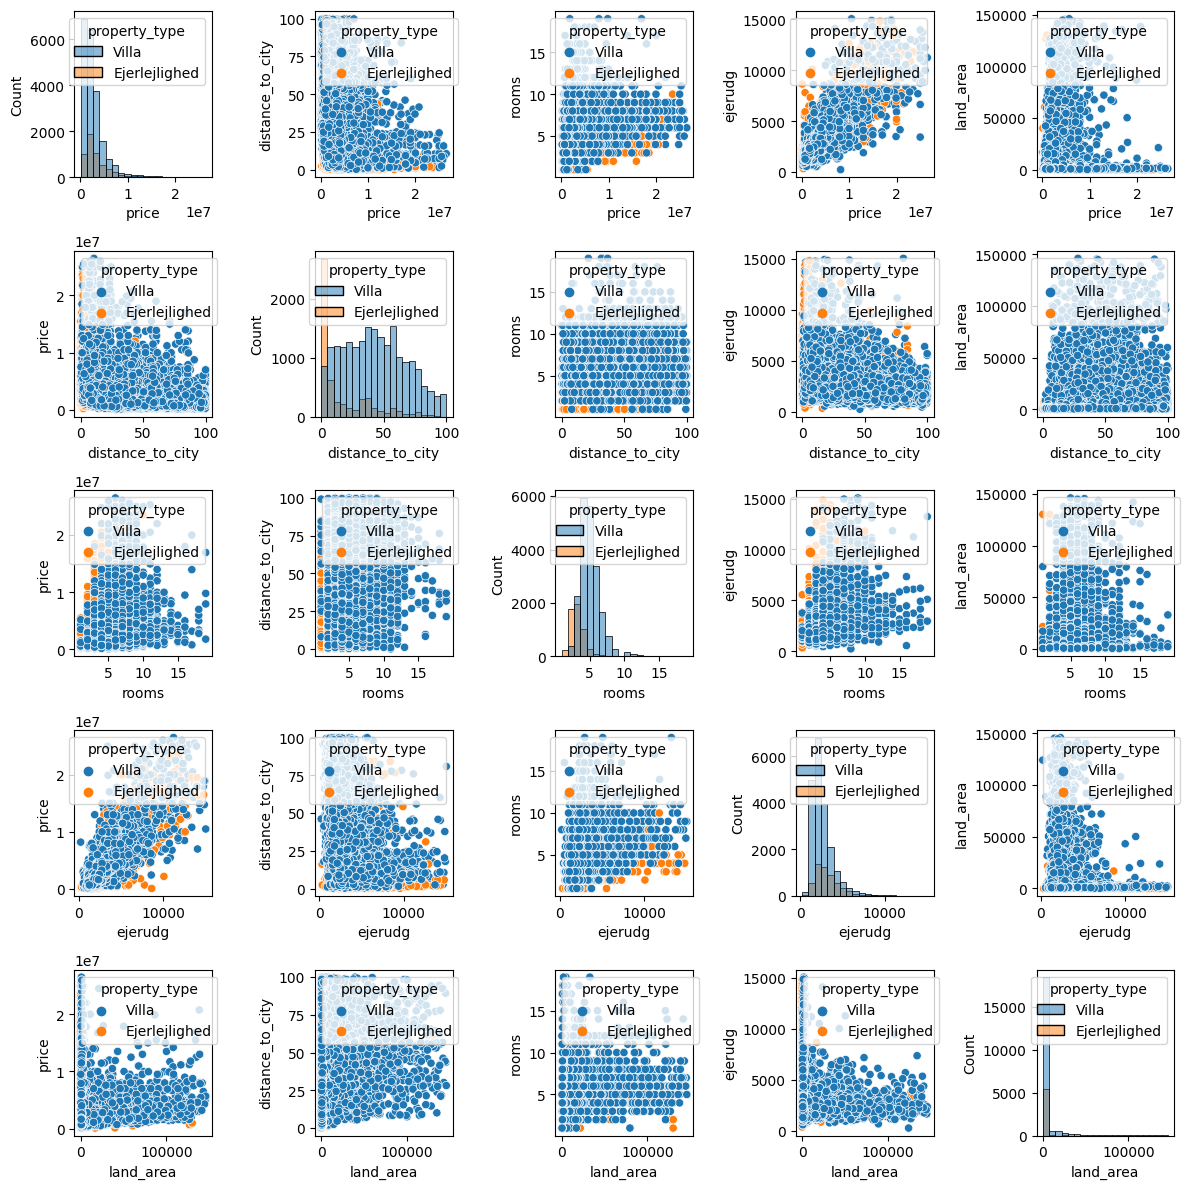

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_columns = ['price', 'distance_to_city', 'rooms', 'ejerudg', 'land_area']

# Create scatter plots
fig, axes = plt.subplots(nrows=len(selected_columns), ncols=len(selected_columns), figsize=(12, 12))

for i, col1 in enumerate(selected_columns):
    for j, col2 in enumerate(selected_columns):
        if col1 != col2:
            sns.scatterplot(data=df_final, x=col1, y=col2, hue='property_type', ax=axes[i, j])
            axes[i, j].set_xlabel(col1)
            axes[i, j].set_ylabel(col2)
        elif col1 == col2:
            sns.histplot(data=df_final, x=col1, bins=20,hue ='property_type',ax=axes[i, j])

plt.tight_layout()
plt.show()
df_final = df_final.drop(columns=['property_type']) 

# New

Models:   0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\Augus\code\Data\venv_jupyter\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.133e+16, tolerance: 1.264e+13
  model = cd_fast.enet_coordinate_descent(
c:\Users\Augus\code\Data\venv_jupyter\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.78866e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Augus\code\Data\venv_jupyter\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+16, tolerance: 1.264e+13
  model = cd_fast.enet_coordinate_descent(


ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

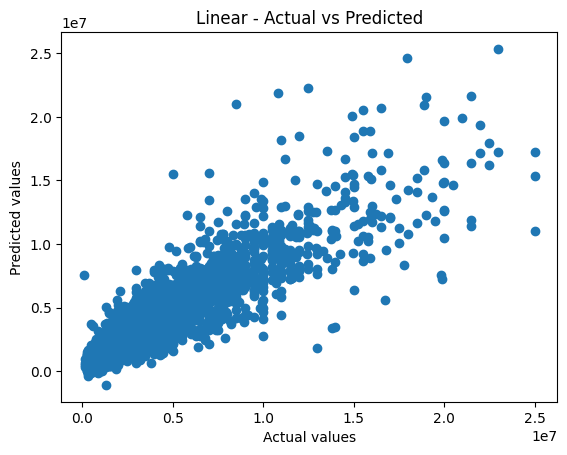

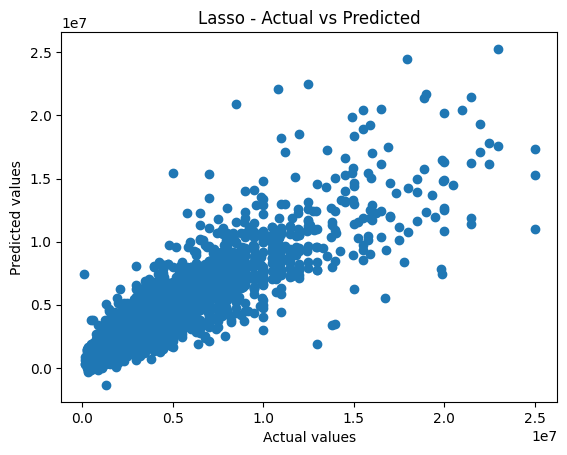

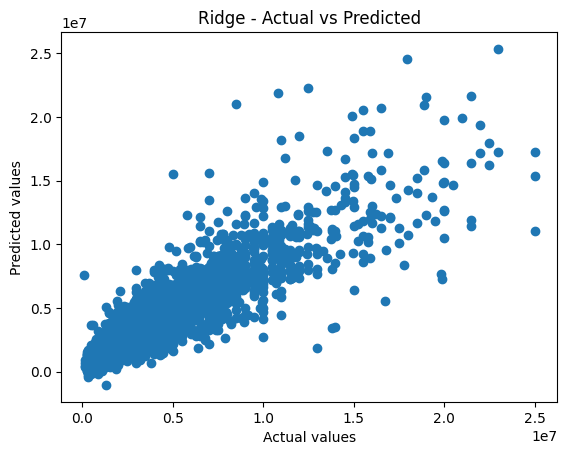

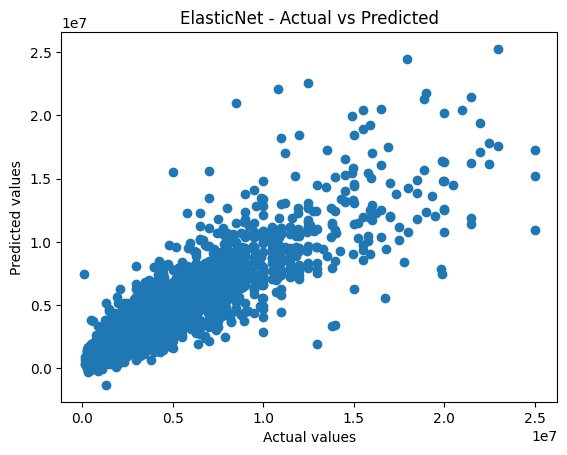

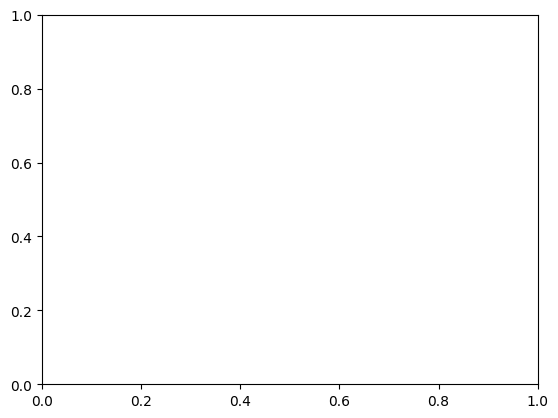

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
#df_final.to_csv('ml.csv',sep=';')

# Loading the data
df = pd.read_csv('ml.csv', sep=';')
X = df.drop('price', axis=1)
y = df['price']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Models and parameters
models = {
    'Linear': LinearRegression(),
    'Lasso': Lasso(max_iter=5000),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(max_iter=5000)
}

params = {
    'Linear': {'polynomialfeatures__degree': [1, 2]},
    'Lasso': {'polynomialfeatures__degree': [1, 2], 'lasso__alpha': [0.001, 0.01, 0.1, 1, 10]},
    'Ridge': {'polynomialfeatures__degree': [1, 2], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10]},
    'ElasticNet': {'polynomialfeatures__degree': [1, 2], 'elasticnet__alpha': [0.001, 0.01, 0.1, 1, 10], 'elasticnet__l1_ratio': [0.2, 0.5, 0.8]}
}

results = []
mse_vs_alpha = {}
r2_and_mse = {
    'Model': [],
    'Training R^2': [],
    'Test R^2': [],
    'Training MSE': [],
    'Test MSE': []
}

for name, model in tqdm(models.items(), desc="Models"):
    pipeline = make_pipeline(PolynomialFeatures(), model)
    grid = GridSearchCV(pipeline, params[name], scoring='neg_mean_squared_error', cv=KFold(n_splits=5), n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Storing metrics
    r2_and_mse['Model'].append(name)
    r2_and_mse['Training R^2'].append(r2_score(y_train, y_train_pred))
    r2_and_mse['Test R^2'].append(r2_score(y_test, y_test_pred))
    r2_and_mse['Training MSE'].append(mean_squared_error(y_train, y_train_pred))
    r2_and_mse['Test MSE'].append(mean_squared_error(y_test, y_test_pred))
    
    # Storing results for plotting
    results.append((y_test, y_test_pred))
    
    if name != 'Linear':
        mse_vs_alpha[name] = grid.cv_results_['mean_test_score']

# Plotting
for (y_test, y_pred), name in zip(results, models.keys()):
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.title(f'{name} - Actual vs Predicted')

for name, mse_values in mse_vs_alpha.items():
    plt.figure()
    plt.plot(params[name].get('lasso__alpha') or params[name].get('ridge__alpha') or params[name].get('elasticnet__alpha'), -mse_values)
    plt.xlabel('Alpha')
    plt.ylabel('Mean Squared Error')
    plt.title(f'{name} - MSE vs Alpha')

metrics_df = pd.DataFrame(r2_and_mse)
print(metrics_df)

plt.show()


# Pipeline Setup

In [6]:
#df_final = df_final.drop(columns=['property_type']) 
# Define target and features
y = df_final['price']
X = df_final.drop(columns=['price'])
# Split the data
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
# Polynomial feature creation and scaling
degrees = [1,2]
poly = PolynomialFeatures(degree=degrees, include_bias=False)
X_poly_dev = poly.fit_transform(X_dev)
X_poly_test = poly.transform(X_test)
scaler = StandardScaler()
X_poly_dev_scaled = scaler.fit_transform(X_poly_dev)
X_poly_test_scaled = scaler.transform(X_poly_test)

# Defining the models dictionary which includes the regression models and their hyperparameters
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': np.logspace(-6, 6, 13)
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': np.logspace(-6, 6, 13)
        }
    },
    'Elastic Net': {
        'model': ElasticNet(),
        'params': {
            'alpha': np.logspace(-6, 6, 13),
            'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        }
    }
}

train_rmse_results = {}
test_rmse_results = {}
r2_train_results = {}
r2_test_results = {}
# Storing model details for later analysis
model_details = {}


# Training

Training Models:   0%|          | 0/4 [00:00<?, ?model/s]

LinearRegression()


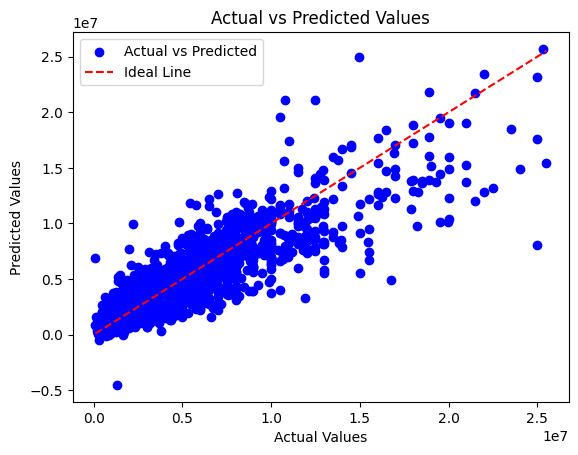

Training Models:   0%|          | 0/4 [00:00<?, ?model/s]


NameError: name 'pipe_lr' is not defined

In [ ]:
for name, model_info in tqdm(models.items(), desc="Training Models", unit="model"):
    for degree in degrees:
        if model_info['params']:
            gs = GridSearchCV(model_info['model'], model_info['params'], cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
            gs.fit(X_poly_dev_scaled, y_dev)
            best_model = gs.best_estimator_
            best_alpha = gs.best_params_['alpha']
        else:
            best_model = model_info['model']
            best_model.fit(X_poly_dev_scaled, y_dev)
            best_alpha = None  # For Linear Regression
        # Evaluation
        y_train_pred = best_model.predict(X_poly_dev_scaled)
        train_rmse = np.sqrt(mse(y_dev, y_train_pred))
        r2_train = r2_score(y_dev, y_train_pred)
        y_test_pred = best_model.predict(X_poly_test_scaled)
        test_rmse = np.sqrt(mse(y_test, y_test_pred))
        r2_test = r2_score(y_test, y_test_pred)
        
        # Storing results for later analysis
        train_rmse_results[name] = train_rmse
        test_rmse_results[name] = test_rmse
        r2_train_results[name] = r2_train
        r2_test_results[name] = r2_test
        print(model_info['model'])
        # Storing model details
        model_details[name] = {
            'Weights': best_model.coef_,
            'Alpha (if applicable)': best_alpha,
        }
        plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', label='Ideal Line')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Actual vs Predicted Values')
        plt.legend()
        plt.show()
        coefficients = pipe_lr.get_params(deep=True)
        coefficients = pipe_lr.named_steps['linearregression'].coef_
        print("Coefficients:", coefficients)
        scaling_factors = pipe_lr.named_steps['standardscaler'].scale_
        rescaled_coefficients = coefficients / scaling_factors
        # Create a DataFrame with rescaled coefficients and feature names
        coef_df = pd.DataFrame(rescaled_coefficients, X.columns, columns=['Coefficient'])

        # Split coefficients into positive and negative parts
        positive_coef = coef_df[coef_df['Coefficient'] > 0]
        negative_coef = coef_df[coef_df['Coefficient'] < 0]

        # Create subplots with positive and negative coefficients
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        positive_coef.plot(kind='barh', ax=ax1)
        negative_coef.plot(kind='barh', ax=ax2)

        ax1.set_title('Positive Coefficients')
        ax2.set_title('Negative Coefficients')

        plt.tight_layout()
        plt.show()

# Performance

In [9]:

# Return the model details for analysis
model_details
# Extracting weights and alpha
weights = best_model.coef_
if 'alpha' in gs.best_params_:
    best_alpha = gs.best_params_['alpha']
else:
    best_alpha = None  # For Linear Regression
    
# train_rmse_results, test_rmse_results, r2_train_results, r2_test_results
print(train_rmse_results, test_rmse_results, r2_train_results, r2_test_results)

{'Linear Regression': 1131340.4858437001, 'Lasso': 1144900.8593085122, 'Ridge': 1131341.0514262589, 'Elastic Net': 1140673.4292704847} {'Linear Regression': 1131347.6840018209, 'Lasso': 1139962.3718084942, 'Ridge': 1131870.69966063, 'Elastic Net': 1141785.1476971281} {'Linear Regression': 0.8217990880731979, 'Lasso': 0.8175016144246952, 'Ridge': 0.8217989098998644, 'Elastic Net': 0.818846839750899} {'Linear Regression': 0.814403173826033, 'Lasso': 0.8115659452325337, 'Ridge': 0.8142315334273209, 'Elastic Net': 0.8109628592654418}


In [10]:
print("Training RSME: ", train_rmse_results)
print("Test RSME: ", test_rmse_results)
print("Training R^2: ", r2_train_results)
print("Test R^2: ", r2_test_results)

Training RSME:  {'Linear Regression': 1131340.4858437001, 'Lasso': 1144900.8593085122, 'Ridge': 1131341.0514262589, 'Elastic Net': 1140673.4292704847}
Test RSME:  {'Linear Regression': 1131347.6840018209, 'Lasso': 1139962.3718084942, 'Ridge': 1131870.69966063, 'Elastic Net': 1141785.1476971281}
Training R^2:  {'Linear Regression': 0.8217990880731979, 'Lasso': 0.8175016144246952, 'Ridge': 0.8217989098998644, 'Elastic Net': 0.818846839750899}
Test R^2:  {'Linear Regression': 0.814403173826033, 'Lasso': 0.8115659452325337, 'Ridge': 0.8142315334273209, 'Elastic Net': 0.8109628592654418}
